# Analyse Candy Power

Let's first import the necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from kmodes.kprototypes import KPrototypes
import sklearn.tree as tree
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

## Importing Data

In [2]:
data_url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/candy-data.csv'
df = pd.read_csv(data_url)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   competitorname    85 non-null     object 
 1   chocolate         85 non-null     int64  
 2   fruity            85 non-null     int64  
 3   caramel           85 non-null     int64  
 4   peanutyalmondy    85 non-null     int64  
 5   nougat            85 non-null     int64  
 6   crispedricewafer  85 non-null     int64  
 7   hard              85 non-null     int64  
 8   bar               85 non-null     int64  
 9   pluribus          85 non-null     int64  
 10  sugarpercent      85 non-null     float64
 11  pricepercent      85 non-null     float64
 12  winpercent        85 non-null     float64
dtypes: float64(3), int64(9), object(1)
memory usage: 8.8+ KB


,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


We are going to divide the winpercent by 100 to put it on the same scale as the other percentage measures.

In [3]:
df['winpercent'] /= 100
df.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,0.669717
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,0.676029
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,0.322611
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,0.461165
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,0.523415


We need to filter out the dime and the quarter that were put in the dataset as a joke because these donot give us any information on actual values of candies. For the rest, there is no extra steps necessary here as the dataset is complete

In [4]:
df = df[df['competitorname'] != 'One dime']
df = df[df['competitorname'] != 'One quarter']
df.reset_index(drop= True, inplace=True)
df

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,0.669717
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,0.676029
2,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,0.523415
3,Almond Joy,1,0,0,1,0,0,0,1,0,0.465,0.767,0.503475
4,Baby Ruth,1,0,1,1,1,0,0,1,0,0.604,0.767,0.569145
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,0.454663
79,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,0.390119
80,WelchÕs Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,0.443755
81,WertherÕs Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,0.419043


## Data Exploration

### Variable Distributions

#### Numeric Variables

In [5]:
numeric_features = ['sugarpercent', 'pricepercent']
df[numeric_features + ['winpercent']].describe()

,sugarpercent,pricepercent,winpercent
count,83.000000,83.000000,83.000000
mean,0.489916,0.472627,0.505849
std,0.276498,0.286503,0.147489
min,0.034000,0.011000,0.224453
25%,0.267000,0.261000,0.391633
50%,0.465000,0.465000,0.489827
75%,0.732000,0.703000,0.603323
max,0.988000,0.976000,0.841803


C:\Users\sdr\AppData\Local\Temp\ipykernel_22792\871000080.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


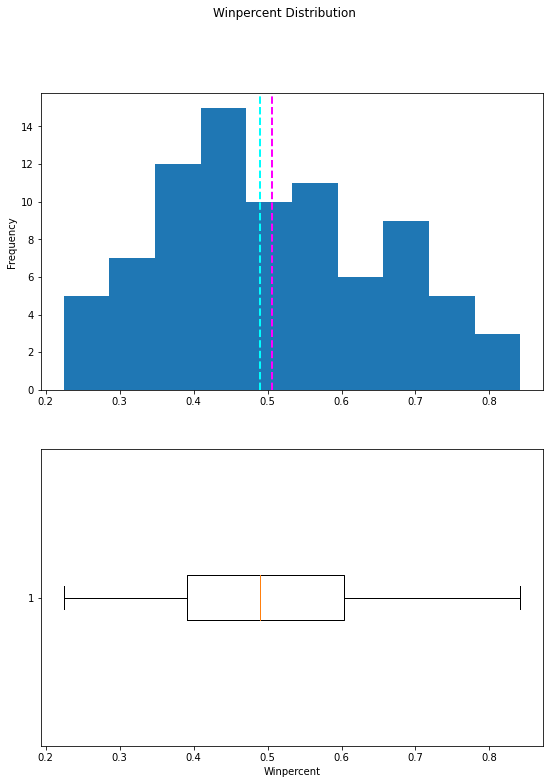

In [6]:
label = df['winpercent']

fig, ax = plt.subplots(2,1, figsize = (9,12))

ax[0].hist(label, bins = 10)
ax[0].set_ylabel('Frequency')
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Winpercent')

fig.suptitle('Winpercent Distribution')

fig.show()

In [7]:
stats.skew(df['winpercent'])

0.300000119332087

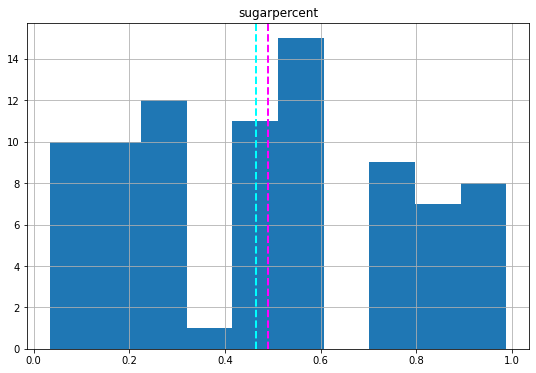

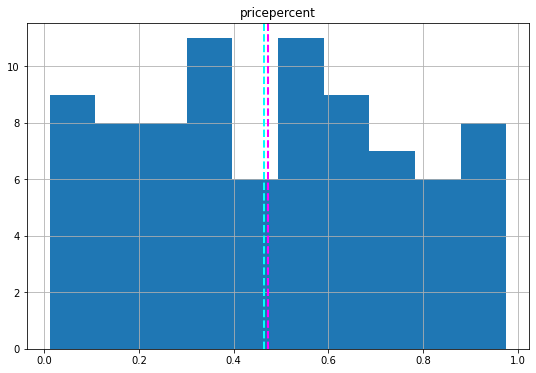

In [8]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    feature.hist(bins=10, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

#### Categorical variables

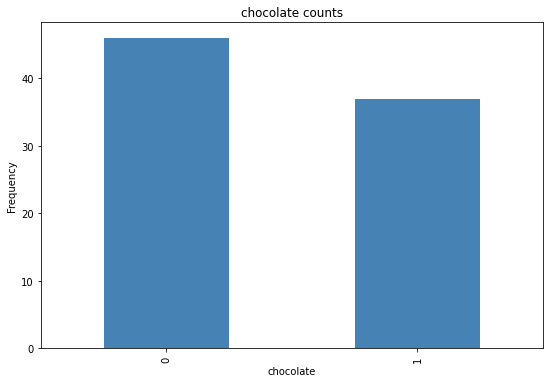

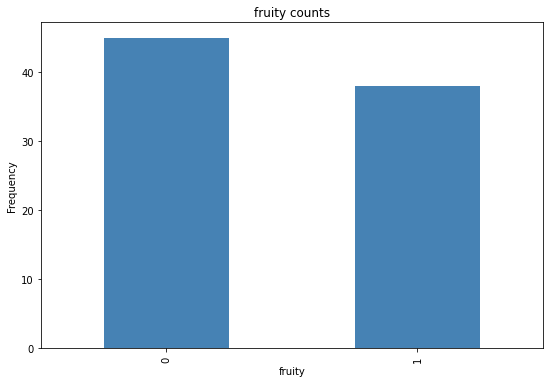

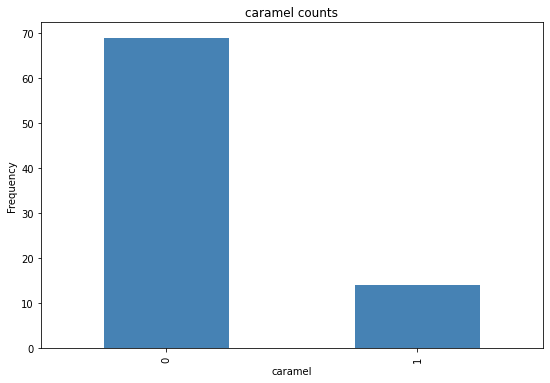

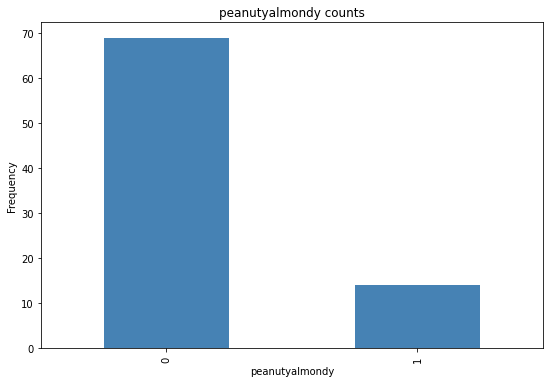

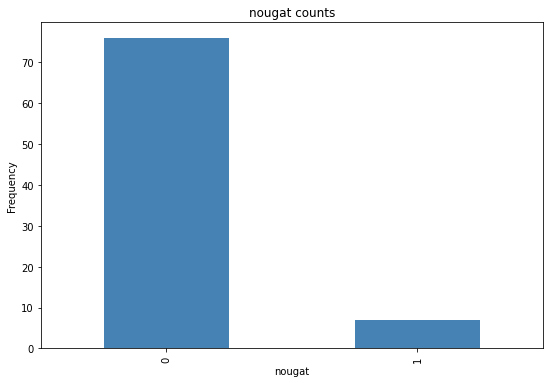

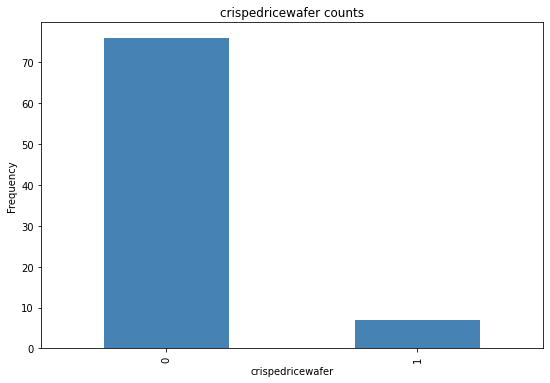

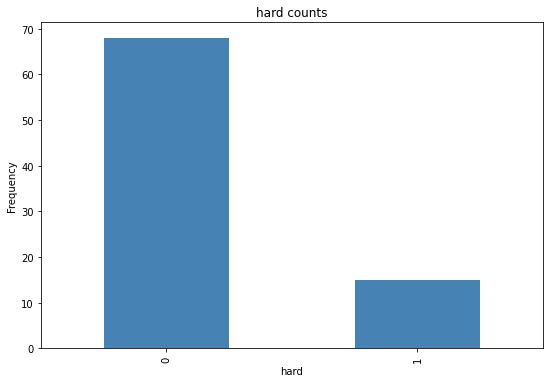

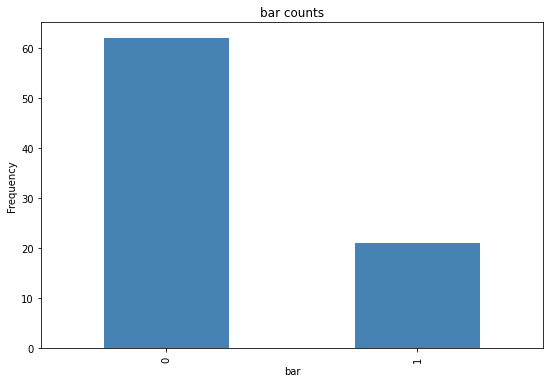

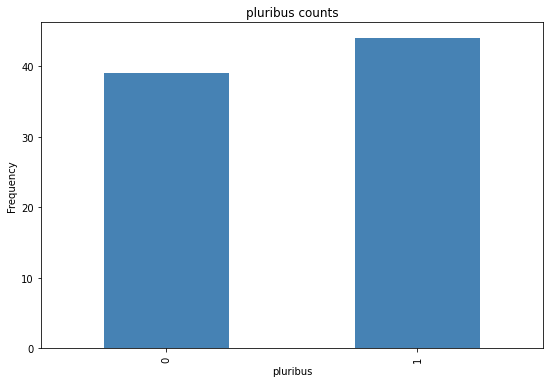

In [9]:
categorical_features = ['chocolate','fruity','caramel','peanutyalmondy','nougat','crispedricewafer', 'hard','bar','pluribus']

for col in categorical_features:
    counts = df[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()

### Multicollinearity

#### Correlation Matrix

In [10]:
df[df.columns[1:]].corr()

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
chocolate,1.000000,-0.775500,0.243325,0.372786,0.251167,0.338392,-0.358230,0.593165,-0.369810,0.072069,0.502438,0.632373
fruity,-0.775500,1.000000,-0.349349,-0.413928,-0.278887,-0.278887,0.385407,-0.534810,0.283713,-0.073631,-0.451413,-0.405264
caramel,0.243325,-0.349349,1.000000,0.054865,0.326416,0.210636,-0.127943,0.329919,-0.285049,0.211804,0.251414,0.207772
peanutyalmondy,0.372786,-0.413928,0.054865,1.000000,0.210636,-0.020924,-0.211559,0.255910,-0.220583,0.072723,0.306888,0.402892
nougat,0.251167,-0.278887,0.326416,0.210636,1.000000,-0.092105,-0.142539,0.521469,-0.322356,0.115097,0.150817,0.195987
crispedricewafer,0.338392,-0.278887,0.210636,-0.020924,-0.092105,1.000000,-0.142539,0.421741,-0.235488,0.060040,0.327728,0.322650
hard,-0.358230,0.385407,-0.127943,-0.211559,-0.142539,-0.142539,1.000000,-0.273341,0.003023,0.076022,-0.253483,-0.322812
bar,0.593165,-0.534810,0.329919,0.255910,0.521469,0.421741,-0.273341,1.000000,-0.618170,0.080044,0.517721,0.425203
pluribus,-0.369810,0.283713,-0.285049,-0.220583,-0.322356,-0.235488,0.003023,-0.618170,1.000000,0.004191,-0.239779,-0.272584
sugarpercent,0.072069,-0.073631,0.211804,0.072723,0.115097,0.060040,0.076022,0.080044,0.004191,1.000000,0.321587,0.207635


#### Cramers V (categorical variables)

In [11]:
def cramers_v(var1,var2):
    confusion_matrix = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    chi2 = stats.chi2_contingency(confusion_matrix, correction = False)[0]
    n = np.sum(confusion_matrix)
    minDim = min(confusion_matrix.shape)-1
    V = np.sqrt((chi2/n) / minDim)
    return V

In [12]:
rows= []

for var1 in df[categorical_features]:
  col = []
  for var2 in df[categorical_features] :
    cramers = cramers_v(df[categorical_features][var1], df[categorical_features][var2])
    col.append(round(cramers,2)) 
  rows.append(col)
  
cramers_results = np.array(rows)
cramermatrix = pd.DataFrame(cramers_results, columns = df[categorical_features].columns, index =df[categorical_features].columns)
cramermatrix

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus
chocolate,1.00,0.78,0.24,0.37,0.25,0.34,0.36,0.59,0.37
fruity,0.78,1.00,0.35,0.41,0.28,0.28,0.39,0.53,0.28
caramel,0.24,0.35,1.00,0.05,0.33,0.21,0.13,0.33,0.29
peanutyalmondy,0.37,0.41,0.05,1.00,0.21,0.02,0.21,0.26,0.22
nougat,0.25,0.28,0.33,0.21,1.00,0.09,0.14,0.52,0.32
crispedricewafer,0.34,0.28,0.21,0.02,0.09,1.00,0.14,0.42,0.24
hard,0.36,0.39,0.13,0.21,0.14,0.14,1.00,0.27,0.00
bar,0.59,0.53,0.33,0.26,0.52,0.42,0.27,1.00,0.62
pluribus,0.37,0.28,0.29,0.22,0.32,0.24,0.00,0.62,1.00


## Analysis

### Univariate Analysis

In [13]:
def boxplot_winpercent(df,col):
    df.boxplot(column = 'winpercent', by = col, figsize=(9,6))
    plt.title('Label by ' + col)
    plt.ylabel("winpercent")
    plt.show()
    print('p-value = {0:.10%}'.format(stats.ttest_ind(df[df[col] == 0].winpercent, df[df[col] == 1].winpercent)[1]))

In [14]:
def scatterplot_winpercent(df,col):
    plt.figure(figsize = (9,6))
    feature = df[col]
    label = df['winpercent']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Winpercentage')
    plt.title('winpercent vs ' + col + '- correlation: ' + str(correlation))
    plt.show()

#### Chocolate

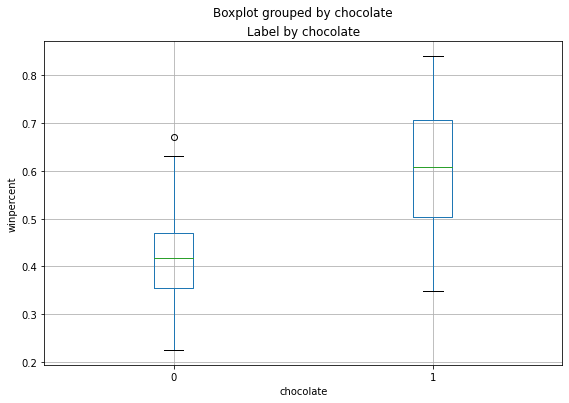

p-value = 0.0000000143%


In [15]:
boxplot_winpercent(df,'chocolate')

There is a significant difference for the winpercentage and it seems like chocolate candy has a higher winpercent.

In [16]:
df[df['chocolate'] == 1]['winpercent'].mean()-df[df['chocolate'] == 0]['winpercent'].mean()

0.18650861035840188

#### Fruity

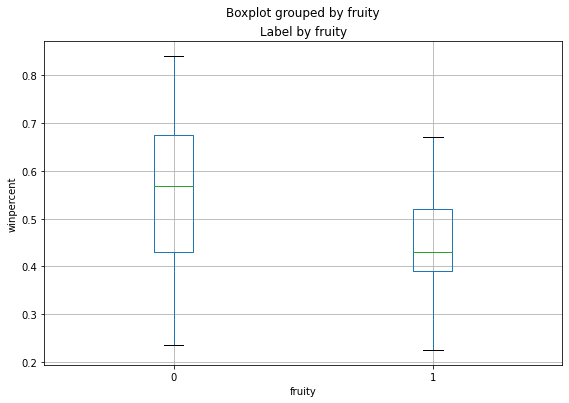

p-value = 0.0144362732%


In [17]:
boxplot_winpercent(df,'fruity')

In [18]:
df[df['fruity'] == 1]['winpercent'].mean()-df[df['fruity'] == 0]['winpercent'].mean()

-0.11924639890058492

In [19]:
pd.crosstab(df['chocolate'], df['fruity'])

fruity,0,1
chocolate,,
0,9,37
1,36,1


There is only 1 candy that is both fruity and chocolaty. It seems that 1 candy can only be 1 of the 2.

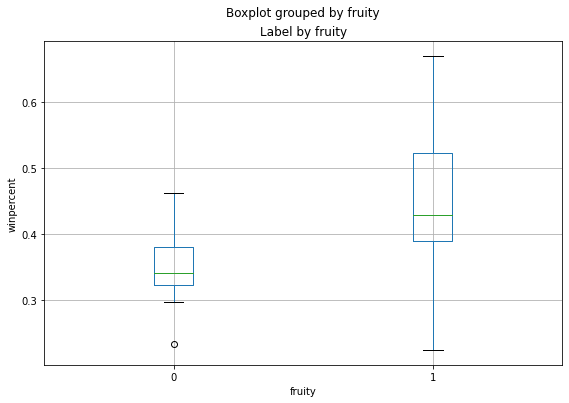

p-value = 2.0356076647%


In [20]:
boxplot_winpercent(df[df['chocolate'] == 0],'fruity')

In [21]:
df[(df['chocolate'] == 0) & (df['fruity'] == 1)]['winpercent'].mean()-df[(df['chocolate'] == 0) & (df['fruity'] == 0)]['winpercent'].mean()

0.08779064543543552

In [22]:
df[(df['fruity'] == 0) & (df['chocolate'] == 0)]

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
5,Boston Baked Beans,0,0,0,1,0,0,0,0,1,0.313,0.511,0.234178
6,Candy Corn,0,0,0,0,0,0,0,0,1,0.906,0.325,0.380110
17,Haribo Happy Cola,0,0,0,0,0,0,0,0,1,0.465,0.465,0.341590
44,Payday,0,0,0,1,1,0,0,1,0,0.465,0.767,0.462966
46,Pixie Sticks,0,0,0,0,0,0,0,0,1,0.093,0.023,0.377223
55,Root Beer Barrels,0,0,0,0,0,0,1,0,1,0.732,0.069,0.297037
68,Sugar Babies,0,0,1,0,0,0,0,0,1,0.965,0.767,0.334375
69,Sugar Daddy,0,0,1,0,0,0,0,0,0,0.418,0.325,0.322310
81,WertherÕs Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,0.419043


It seems like candies that are chocolate-flavoured score better than fruit-flavoured candies. However, people still prefer fruit flavour if chocolate flavour is missing.

#### Caramel

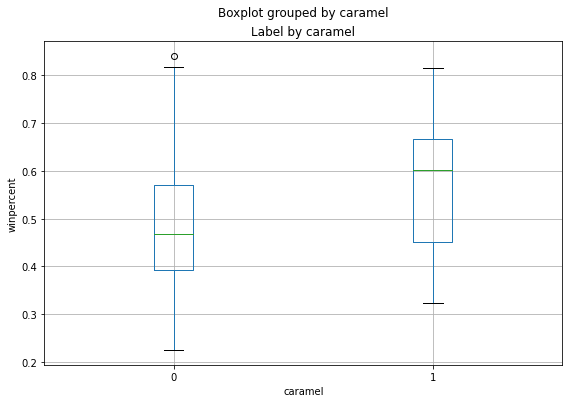

p-value = 5.9455008061%


In [23]:
boxplot_winpercent(df,'caramel')

#### PeanutyAlmondy

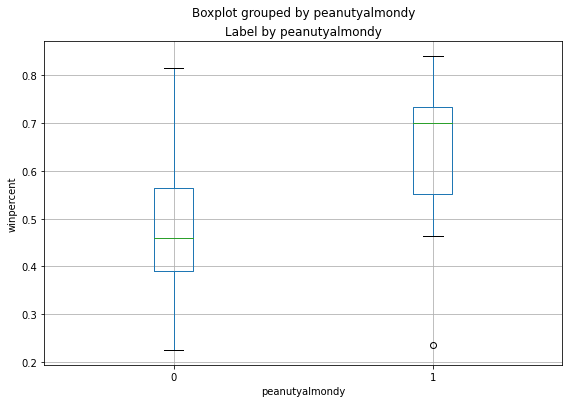

p-value = 0.0159221981%


In [24]:
boxplot_winpercent(df,'peanutyalmondy')

In [25]:
df[df['peanutyalmondy'] == 1]['winpercent'].mean()-df[df['peanutyalmondy'] == 0]['winpercent'].mean()

0.15772681452380954

At first glance, the correlation between peanutyalmondy and winpercent seems interesting. However, since there is quite a high correlation with the chocolate variable, we first take a look at the crosstable.

In [26]:
pd.crosstab(df['chocolate'], df['peanutyalmondy'])

peanutyalmondy,0,1
chocolate,,
0,44,2
1,25,12


We can see that nearly all peanutyalmondy flavoured candy is also chocolate-tasting. The opposite is not true, so let's restrict the dataset to chocolate-tasting only.

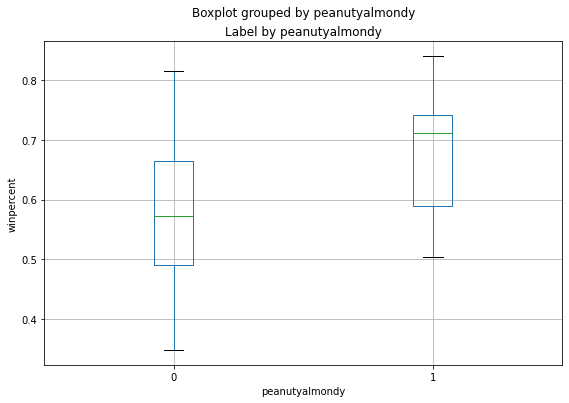

p-value = 1.0503360683%


In [27]:
boxplot_winpercent(df[df['chocolate'] == 1],'peanutyalmondy')

In [28]:
df[(df['chocolate'] == 1) & (df['peanutyalmondy'] == 1)]['winpercent'].mean()-df[(df['chocolate'] == 1) & (df['peanutyalmondy'] == 0)]['winpercent'].mean()

0.11221747406666649

The above plot indeed confirms that candy with peanuts/almonds perform better than without.

#### Nougat

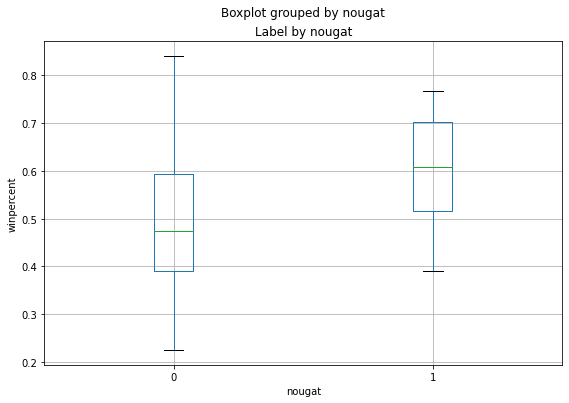

p-value = 7.5781010807%


In [29]:
boxplot_winpercent(df,'nougat')

#### Crispedricewafer

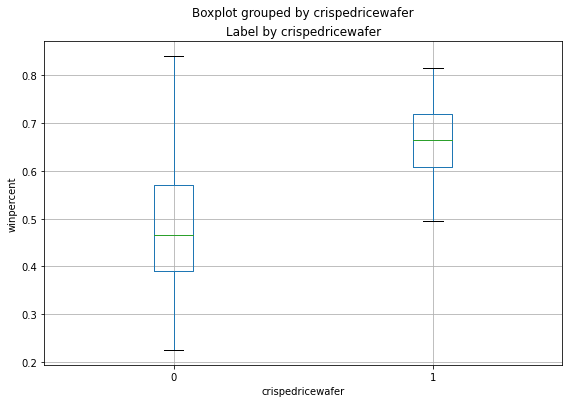

p-value = 0.2930843635%


In [30]:
boxplot_winpercent(df,'crispedricewafer')

In [31]:
pd.crosstab(df['chocolate'], df['crispedricewafer'])

crispedricewafer,0,1
chocolate,,
0,46,0
1,30,7


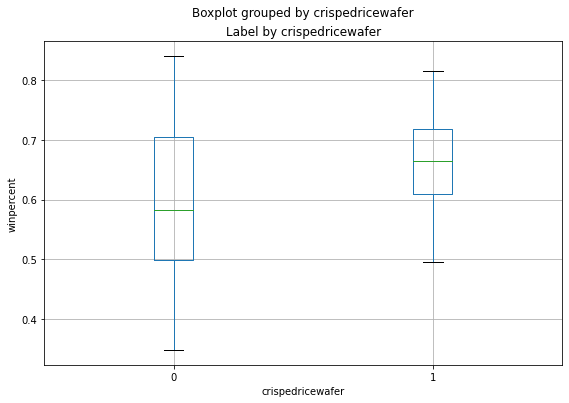

p-value = 23.3781292330%


In [32]:
boxplot_winpercent(df[df['chocolate'] == 1],'crispedricewafer')

#### Hard

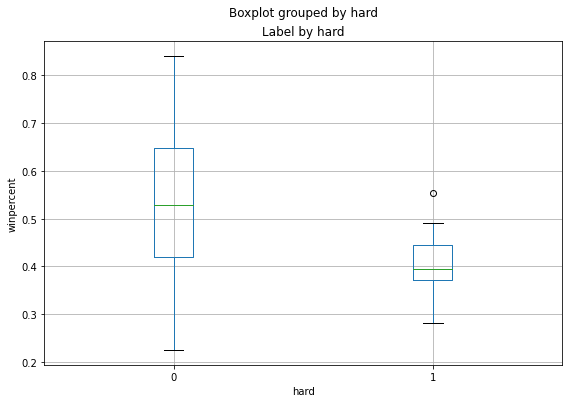

p-value = 0.2915827118%


In [33]:
boxplot_winpercent(df,'hard')

Let's look at the correlation with fruity

In [34]:
pd.crosstab(df['fruity'], df['hard'])

hard,0,1
fruity,,
0,43,2
1,25,13


It seems again that the vast majority of hard candies are fruity. so we fix the level of fruity

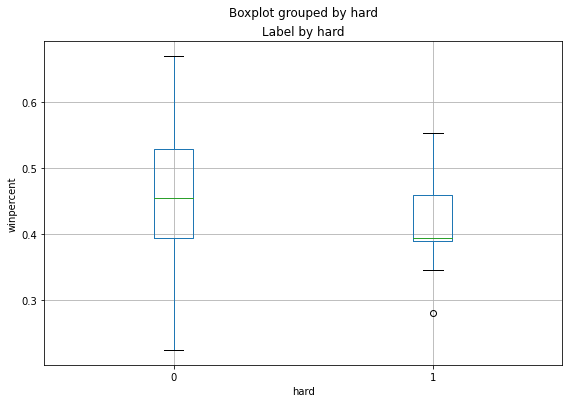

p-value = 21.5699878413%


In [35]:
boxplot_winpercent(df[df['fruity'] == 1],'hard')

#### Bar

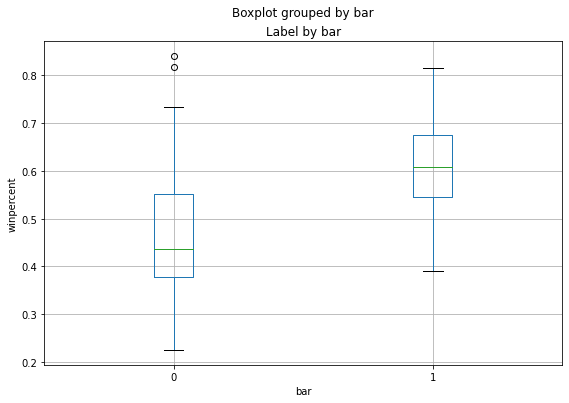

p-value = 0.0061507981%


In [36]:
boxplot_winpercent(df,'bar')

At first glance, the correlation between bar and winpercent seems interesting. However, since there is quite a high correlation with the chocolate variable, we first take a look at the crosstable.

In [37]:
pd.crosstab(df['chocolate'], df['bar'])

bar,0,1
chocolate,,
0,45,1
1,17,20


We can observe that there is only 1 candybar that does not have a chocolate flavor, so we can not really say significant things for whether or not a candybar has a higher win percentage if it does not taste like chocolate. What we can say is that nearly all candybars are also chocolate flavoured. Not all chocolate flavoured candies are candybars however, so let's have a look at the boxplots when we restrict the dataset to chocolate-flavoured candy.

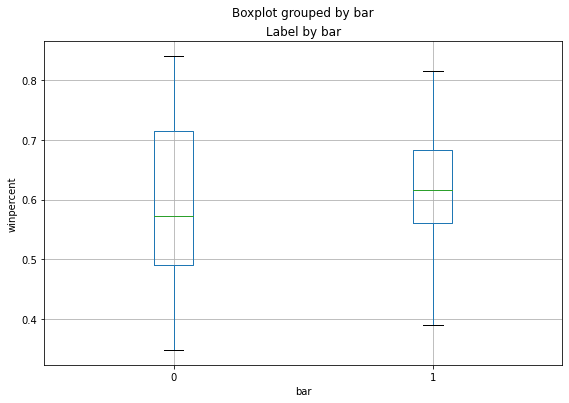

p-value = 57.0077723499%


In [38]:
boxplot_winpercent(df[df['chocolate']==1],'bar')

We see here that there is no significant difference between candybars/non candybars for chocolate flavoured candies.

#### Pluribus

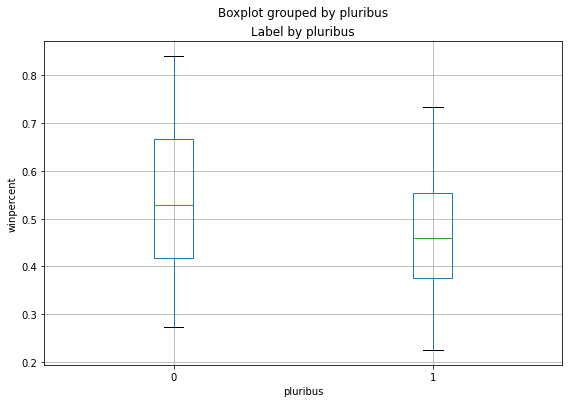

p-value = 1.2663239057%


In [39]:
boxplot_winpercent(df,'pluribus')

In [40]:
df[df['pluribus'] == 1]['winpercent'].mean()-df[df['pluribus'] == 0]['winpercent'].mean()

-0.08006577566433576

#### Sugarpercent

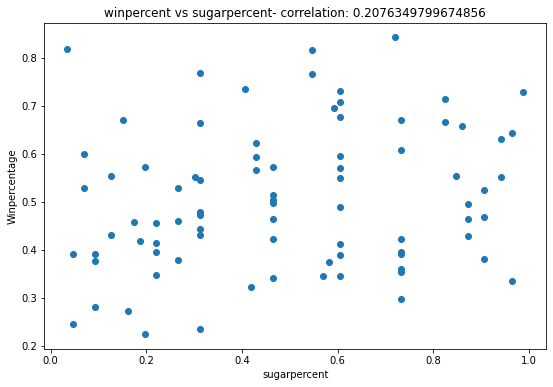

In [41]:
scatterplot_winpercent(df,'sugarpercent')

#### Pricepercent

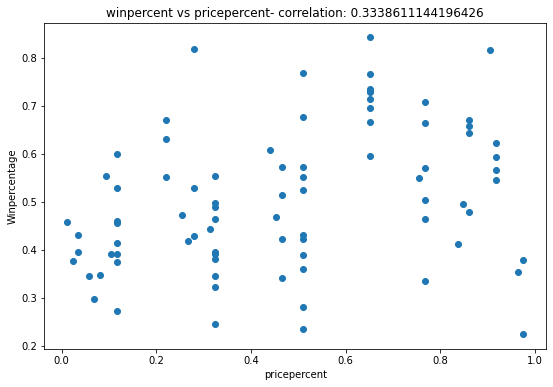

In [42]:
scatterplot_winpercent(df,'pricepercent')

### Multivariate Analysis

#### Regression Analysis

In [43]:
df_features = df.iloc[:,1:-1]
df_features['sugarpercent^2'] = df['sugarpercent']**2
df_features['sugarpercent^3'] = df['sugarpercent']**3
df_features['pricepercent^2'] = df['pricepercent']**2
df_features['pricepercent^3'] = df['pricepercent']**3

In [44]:
df_features

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,sugarpercent^2,sugarpercent^3,pricepercent^2,pricepercent^3
0,1,0,1,0,0,1,0,1,0,0.732,0.860,0.535824,0.392223,0.739600,0.636056
1,1,0,0,0,1,0,0,1,0,0.604,0.511,0.364816,0.220349,0.261121,0.133433
2,0,1,0,0,0,0,0,0,0,0.906,0.511,0.820836,0.743677,0.261121,0.133433
3,1,0,0,1,0,0,0,1,0,0.465,0.767,0.216225,0.100545,0.588289,0.451218
4,1,0,1,1,1,0,0,1,0,0.604,0.767,0.364816,0.220349,0.588289,0.451218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0,1,0,0,0,0,0,0,0,0.220,0.116,0.048400,0.010648,0.013456,0.001561
79,0,1,0,0,0,0,1,0,0,0.093,0.116,0.008649,0.000804,0.013456,0.001561
80,0,1,0,0,0,0,0,0,1,0.313,0.313,0.097969,0.030664,0.097969,0.030664
81,0,0,1,0,0,0,1,0,0,0.186,0.267,0.034596,0.006435,0.071289,0.019034


In [45]:
X = sm.add_constant(df_features)
y = df['winpercent']

In [46]:
result = sm.OLS(y,X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             winpercent   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     5.939
Date:                Thu, 18 Aug 2022   Prob (F-statistic):           1.30e-07
Time:                        23:25:24   Log-Likelihood:                 76.690
No. Observations:                  83   AIC:                            -121.4
Df Residuals:                      67   BIC:                            -82.68
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3677      0.086      4.254      0.000       0.195       0.540
chocolate            0.2076      0.042      4.973      0.000       0.124       0.291
fruity               0.1079      0.042      2.549      0.013       0.023       0.192
caramel              0.0225      0.037      0.609      0.545      -0.051       0.096
peanutyalmondy       0.0922      0.040      2.315      0.024       0.013       0.172
nougat              -0.0121      0.061     -0.198      0.844      -0.135       0.110
crispedricewafer     0.0818      0.054      1.524      0.132      -0.025       0.189
hard                -0.0520      0.037     -1.419      0.161      -0.125       0.021
bar                  0.0427      0.053      0.801      0.426      -0.064       0.149
pluribus             0.0006      0.033      0.019      0.985      -0.064       0.065
sugarpercent        -0.4279      0.533     -0.803      0.425      -1.492       0.636
pricepercent         0.0283      0.462      0.061      0.951      -0.895       0.951
sugarpercent^2       0.7758      1.208      0.642      0.523      -1.635       3.186
sugarpercent^3      -0.3101      0.785     -0.395      0.694      -1.877       1.257
pricepercent^2       0.1968      1.183      0.166      0.868      -2.165       2.559
pricepercent^3      -0.3035      0.814     -0.373      0.711      -1.929       1.322
==============================================================================
Omnibus:                        0.781   Durbin-Watson:                   1.627
Prob(Omnibus):                  0.677   Jarque-Bera (JB):                0.884
Skew:                          -0.208   Prob(JB):                        0.643
Kurtosis:                       2.712   Cond. No.                         223.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
X_adapted = sm.add_constant(df[['chocolate','peanutyalmondy', 'fruity']])

In [48]:
result = sm.OLS(y,X_adapted).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             winpercent   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     22.78
Date:                Thu, 18 Aug 2022   Prob (F-statistic):           1.01e-10
Time:                        23:25:24   Log-Likelihood:                 67.457
No. Observations:                  83   AIC:                            -126.9
Df Residuals:                      79   BIC:                            -117.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3507      0.036      9.780      0.000       0.279       0.422
chocolate          0.2263      0.039      5.857      0.000       0.149       0.303
peanutyalmondy     0.0923      0.036      2.595      0.011       0.022       0.163
fruity             0.0846      0.039      2.152      0.034       0.006       0.163
==============================================================================
Omnibus:                        0.571   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.752   Jarque-Bera (JB):                0.698
Skew:                          -0.088   Prob(JB):                        0.705
Kurtosis:                       2.587   Cond. No.                         6.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We leave fruity out of the equation since its heavily (negatively) correlated with chocolate and therefore there might be some multicollinearity.

In [49]:
X_adapted = sm.add_constant(df[['chocolate','peanutyalmondy']])

In [50]:
result = sm.OLS(y,X_adapted).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             winpercent   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     30.47
Date:                Thu, 18 Aug 2022   Prob (F-statistic):           1.46e-10
Time:                        23:25:24   Log-Likelihood:                 65.092
No. Observations:                  83   AIC:                            -124.2
Df Residuals:                      80   BIC:                            -116.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4194      0.017     25.175      0.000       0.386       0.453
chocolate          0.1652      0.027      6.169      0.000       0.112       0.218
peanutyalmondy     0.0760      0.036      2.138      0.036       0.005       0.147
==============================================================================
Omnibus:                        0.348   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.840   Jarque-Bera (JB):                0.518
Skew:                          -0.032   Prob(JB):                        0.772
Kurtosis:                       2.618   Cond. No.                         3.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We would also like to test whether the amount of 'flavour' features present will also influence the model. We already have chocolate and peanutyalmondy in our model. We also don't have to include fruity as its negatively correlated with chocolate.

In [51]:
X_adapted['extra_flavours'] = df[['caramel', 'nougat', 'crispedricewafer', 'hard']].sum(axis = 1)

In [52]:
result = sm.OLS(y,X_adapted).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             winpercent   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     20.28
Date:                Thu, 18 Aug 2022   Prob (F-statistic):           7.70e-10
Time:                        23:25:24   Log-Likelihood:                 65.288
No. Observations:                  83   AIC:                            -122.6
Df Residuals:                      79   BIC:                            -112.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4145      0.019     22.368      0.000       0.378       0.451
chocolate          0.1619      0.027      5.908      0.000       0.107       0.216
peanutyalmondy     0.0779      0.036      2.174      0.033       0.007       0.149
extra_flavours     0.0116      0.019      0.611      0.543      -0.026       0.049
==============================================================================
Omnibus:                        0.563   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.755   Jarque-Bera (JB):                0.671
Skew:                           0.004   Prob(JB):                        0.715
Kurtosis:                       2.560   Cond. No.                         4.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is no extra influence of the extra presence of features

#### Decision Tree

In [53]:
X = df.iloc[:,1:-1]
y = df['winpercent']

In [54]:
regressor = tree.DecisionTreeRegressor(max_depth = 3)
regressor.fit(X,y)

DecisionTreeRegressor(max_depth=3)

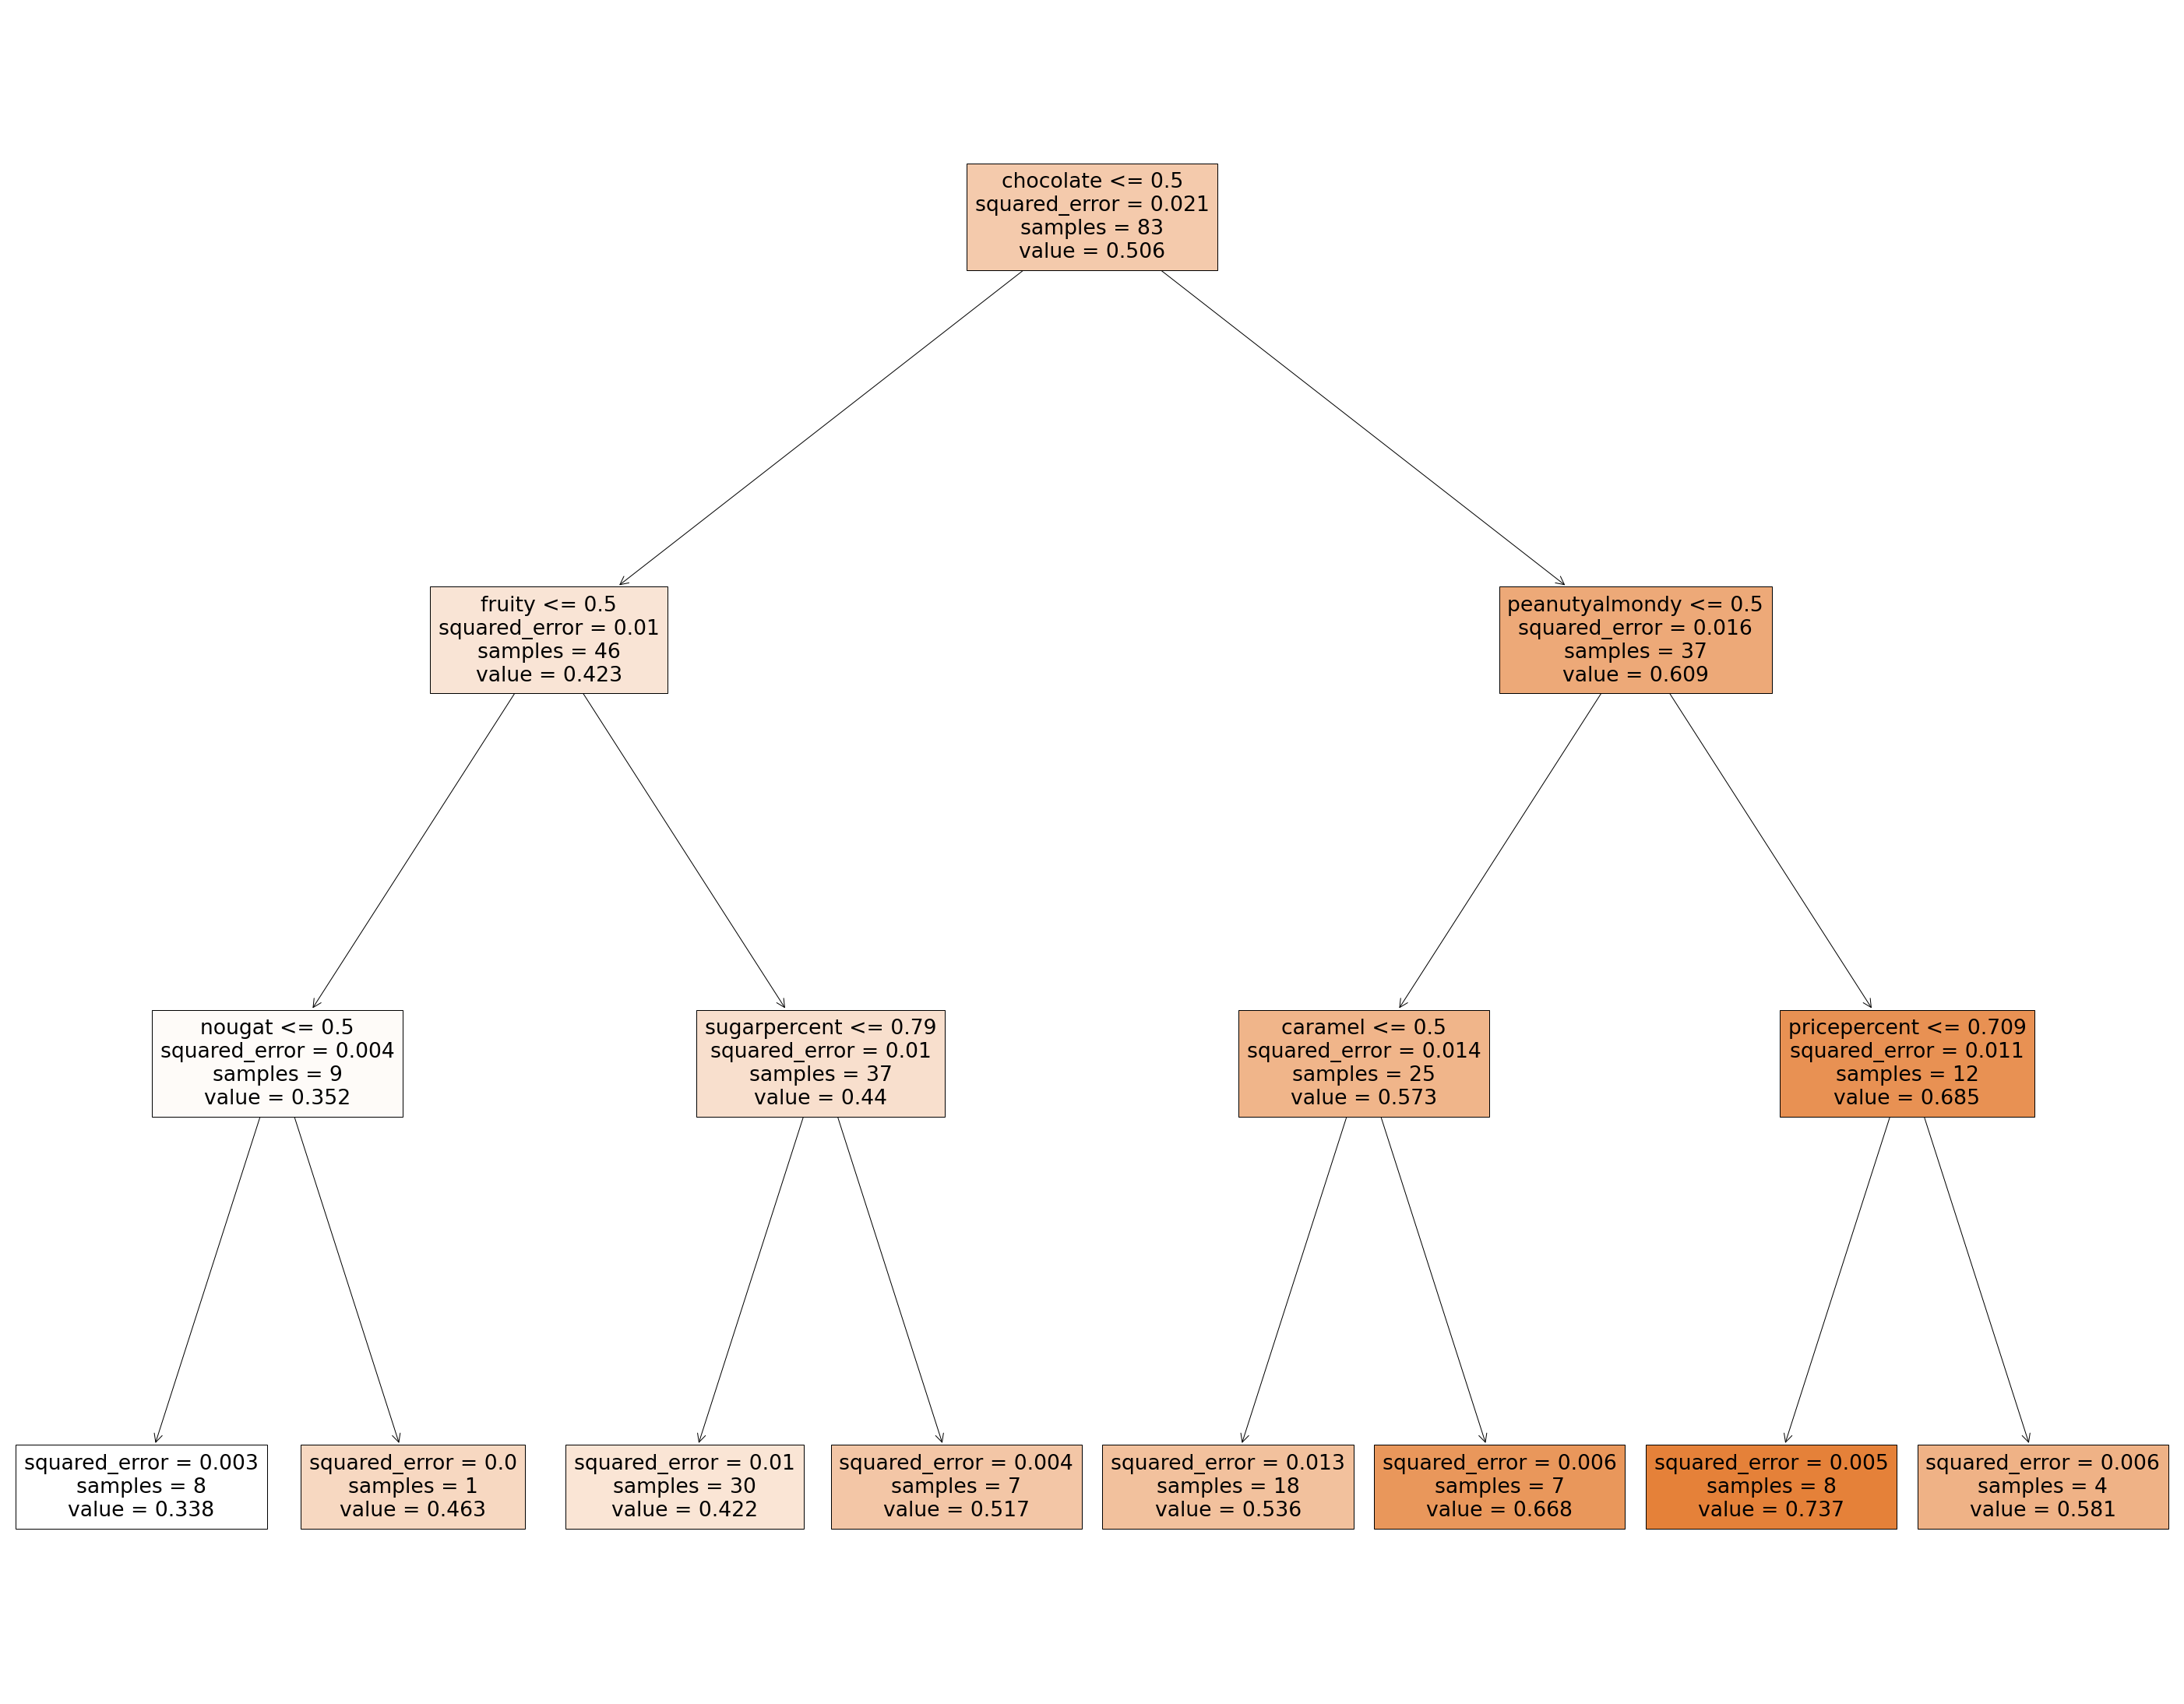

In [55]:
fig = plt.figure(figsize=(50,40))
_ = tree.plot_tree(regressor,
                    feature_names=X.columns,
                    filled=True)

In [56]:
regressor.feature_importances_

array([0.65489807, 0.05122446, 0.08098055, 0.09374217, 0.01269704,
       0.        , 0.        , 0.        , 0.        , 0.04718797,
       0.05926975])

<AxesSubplot:xlabel='importance', ylabel='features'>

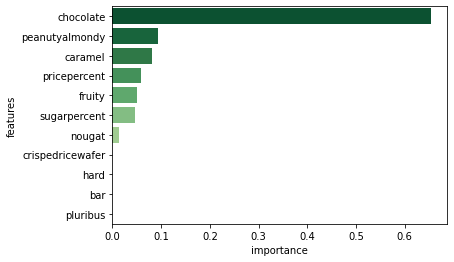

In [57]:
imp = pd.DataFrame({'features': X.columns, 'importance': regressor.feature_importances_})
imp.sort_values('importance', ascending=False, inplace=True)
sns.barplot(x='importance', y='features', data=imp, palette="YlGn_r")

In [58]:
regressor.score(X,y)

0.6106235683410536

We can conclude from these multivariate analyses that there is a limited amount of features of which we can confidently say that they influence the winpercent significantly. For our 'perfect candy', we can only say that the candy has to be chocolate tasting with some peanuts/almonds. We therefore check for the other effects (except for fruity, it seems like a candy in our dataset is chocolate or fruity but not both, we can therefore leave this feature behind and accept that we are going for chocolate tasting)

#### Univariate analysis after fixing chocolate and peanutyalmondy

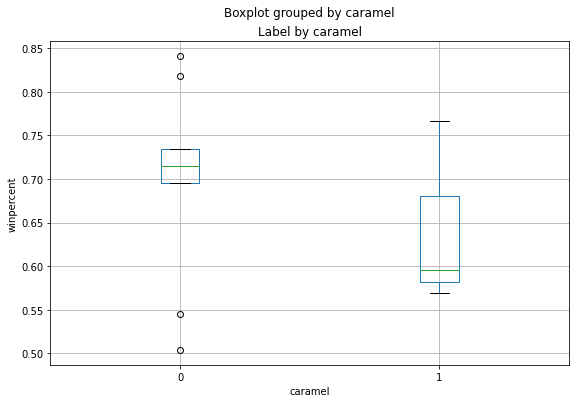

p-value = 47.1813207224%


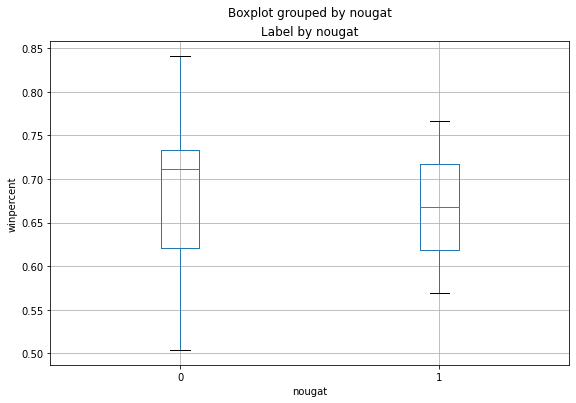

p-value = 81.9779123260%


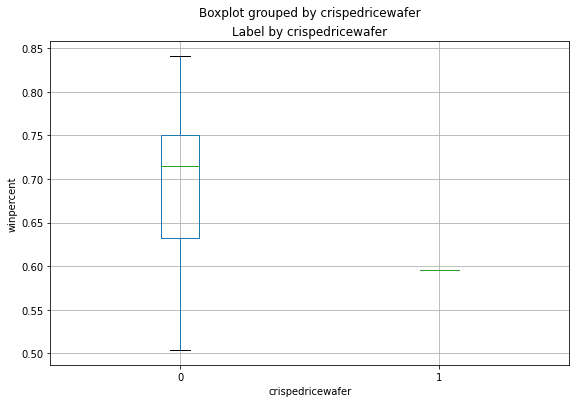

p-value = nan%


C:\Users\sdr\AppData\Local\Temp\ipykernel_22792\168307441.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print('p-value = {0:.10%}'.format(stats.ttest_ind(df[df[col] == 0].winpercent, df[df[col] == 1].winpercent)[1]))
c:\Users\sdr\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\sdr\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


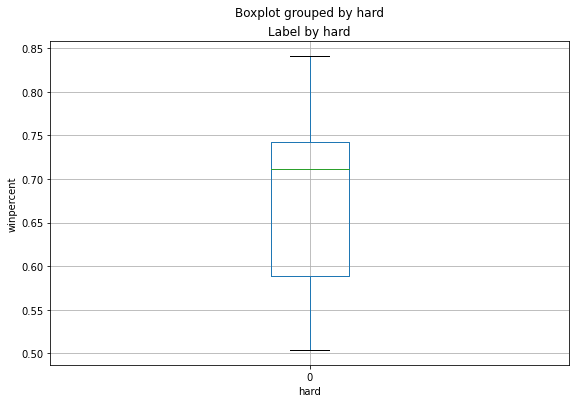

p-value = nan%


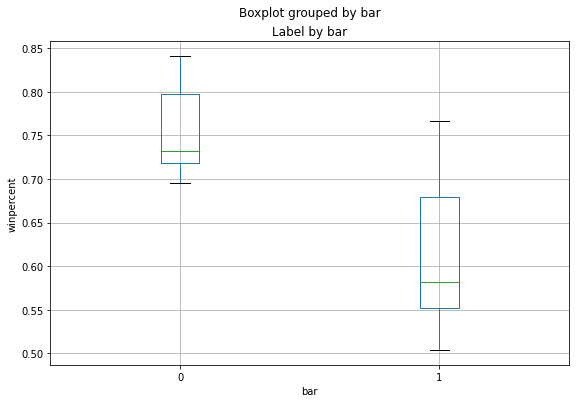

p-value = 1.4947084471%


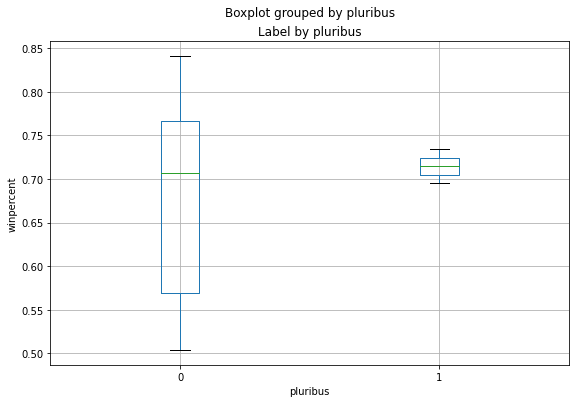

p-value = 60.8903419372%


In [59]:
for col in ['caramel','nougat','crispedricewafer','hard','bar','pluribus']:
    boxplot_winpercent(df[(df['chocolate'] == 1) & (df['peanutyalmondy'] == 1)],col)

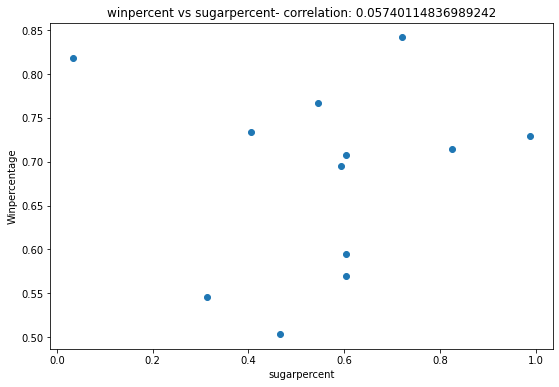

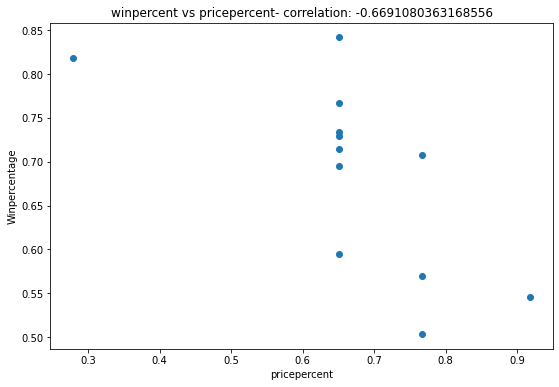

In [60]:
for col in ['sugarpercent','pricepercent']:
    scatterplot_winpercent(df[(df['chocolate'] == 1) & (df['peanutyalmondy'] == 1)],col)

### Bonus: K-Prototype Clustering

In [61]:
df_features = df.iloc[:,1:-1]
df_cat_index = [0,1,2,3,4,5,6,7,8]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 3
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 3
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9
cost (sum distance) for all k:
2 : 24.939
3 : 21.115
4 : 19.499
5 : 17.027
6 : 15.540
7 : 14.370
8 : 13.261
9 : 12.436


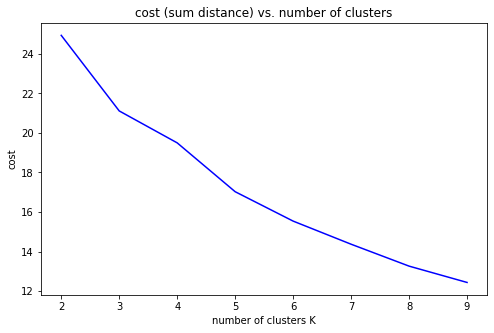

In [62]:
dict_cost_c3 = {}
for k in range(2,10):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_jobs=4, verbose=2)
    res = kproto.fit_predict(df_features, categorical=df_cat_index)
    dict_cost_c3[k] = kproto.cost_

print("cost (sum distance) for all k:")
_ = [print(k,":",f'{v:.3f}') for k,v in dict_cost_c3.items()]


# scree plot: look for elbow
plt.figure(figsize=[8,5])
plt.plot(dict_cost_c3.keys(), dict_cost_c3.values(), color="blue")
plt.title("cost (sum distance) vs. number of clusters")
plt.xticks(np.arange(2,10,1))
plt.xlabel("number of clusters K")
plt.ylabel("cost");

In [63]:
kproto4 = KPrototypes(n_clusters=4, init='Cao', n_jobs=4, verbose=2)
res4 = kproto4.fit_predict(df_features, categorical=df_cat_index)
kproto4.cost_

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 3


19.520385073552152

In [64]:
clusters = pd.DataFrame(kproto4.cluster_centroids_)
clusters = clusters[[2,3,4,5,6,7,8,9,10,0,1]]
clusters.columns = df_features.columns
clusters

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.219258,0.278258
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.594417,0.711917
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.770000,0.404864
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.544056,0.730667


In [65]:
df['cluster_labels'] = kproto4.labels_
clusters['winpercent_mean'] = [df[df['cluster_labels'] == 0]['winpercent'].mean(),df[df['cluster_labels'] == 1]['winpercent'].mean(),df[df['cluster_labels'] == 2]['winpercent'].mean(),df[df['cluster_labels'] == 3]['winpercent'].mean()]
clusters

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent_mean
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.219258,0.278258,0.442019
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.594417,0.711917,0.655397
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.770000,0.404864,0.442471
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.544056,0.730667,0.593542
